## Plan so far:

#### Classification using multiple outputs or multiclass, by replacing sigmoid activation using softmax 
#### Make sure i use linear for the last layer and use from_logits = true to avoid round-off errors
#### Output layer must have 15 units 
#### all hidden layers should have reLU activation 
#### find out how many units each layer should have (hidden)
#### experiment by increasing the n of the dataset
#### apparently tf.random.seed(1234) is used to get consistent results (investigate0

In [9]:
import numpy as np
import os
import cv2
import glob

# Path to your image dataset
IMAGE_FOLDER = "train/"  # Update folder path
OUTPUT_IMAGES = "images.npy"

# Convert images to NumPy array
def create_numpy_dataset(image_folder, output_images):
    image_paths = sorted(glob.glob(os.path.join(image_folder, "img_*.png")))  # Ensure correct order
    print(f"Found {len(image_paths)} images.")

    images = []

    for img_path in image_paths:
        # Read image as grayscale (256x256)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))  # Ensure size consistency
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (for CNNs)

        images.append(image)

    # Convert list to NumPy array
    images = np.array(images, dtype=np.uint8)  # Shape: (num_images, 256, 256, 1)

    # Save array
    np.save(output_images, images)

    print(f"Saved images to {output_images}")

# Run the conversion
create_numpy_dataset(IMAGE_FOLDER, OUTPUT_IMAGES)


Found 2000 images.
Saved images to images.npy


In [10]:
X_train = np.load("images.npy")

print(f"Loaded images shape: {X_train.shape}")  # Expected: (2000, 256, 256, 1)

# Normalize images (optional, recommended for training)
X_train = X_train.astype(np.float32) / 255.0

Loaded images shape: (2000, 256, 256, 1)


In [11]:
print(X_train)

[[[[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10196079]
   [0.09019608]
   [0.10196079]
   ...
   [0.09411765]
   [0.09019608]
   [0.09411765]]

  ...

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]

  [[0.10588235]
   [0.10588235]
   [0.10588235]
   ...
   [0.10588235]
   [0.10588235]
   [0.10588235]]]


 [[[0.01176471]
   [0.01568628]
   [0.00784314]
   ...
   [0.08627451]
   [0.03921569]
   [0.01568628]]

  [[0.01960784]
   [0.03529412]
   [0.01176471]
   ...
   [0.05882353]
   [0.03137255]
   [0.00784314]]

  [[0.05882353]
   [0.03137255]
   [0.01960784]
   ...
   [0.03137255]
   [0.01568628]
   [0.01176471]]

  ...

  [[0.01568628]
   [0.01568628]
   [0.0

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D


model = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='linear')
    ]
)


model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,169 (465.50 KB)

 Trainable params: 118,337 (462.25 KB)

 Non-trainable params: 832 (3.25 KB)

In [51]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),  # or tf.keras.losses.MeanAbsoluteError()
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['mae']  # Tracks mean absolute error during training
)

In [53]:
import pandas as pd
df = pd.read_csv("train_gt.csv")

Y_train = df.iloc[:, 1].values
print("Y_train pre normalization:", Y_train)

## normalizing

Y_train_mean = np.mean(Y_train)
Y_train_std = np.std(Y_train)

Y_train_normalized = (Y_train - Y_train_mean) / Y_train_std  # Use this for training
print("Y_train post normalization:", Y_train_normalized)

Y_train pre normalization: [3 3 3 ... 1 6 1]
Y_train post normalization: [ 0.28198442  0.28198442  0.28198442 ... -1.15487886  2.43727933
 -1.15487886]


In [ ]:
num_samples = X_train.shape[0]
print("Y_train shape: ", Y_train.shape)

model.fit(
    X_train,Y_train_normalized,
    epochs=10
)


Y_train shape:  (2000,)
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 1.5606 - mae: 1.0087
Epoch 2/10


In [47]:
Y_pred_normalized = model.predict(X_train)

Y_pred = (Y_pred_normalized * Y_train_std) + Y_train_mean
Y_pred_final = np.maximum(0, np.round(Y_pred))  # Ensure non-negative, rounded values
print(Y_pred_final)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step
[[3.]
 [2.]
 [3.]
 ...
 [3.]
 [3.]
 [2.]]


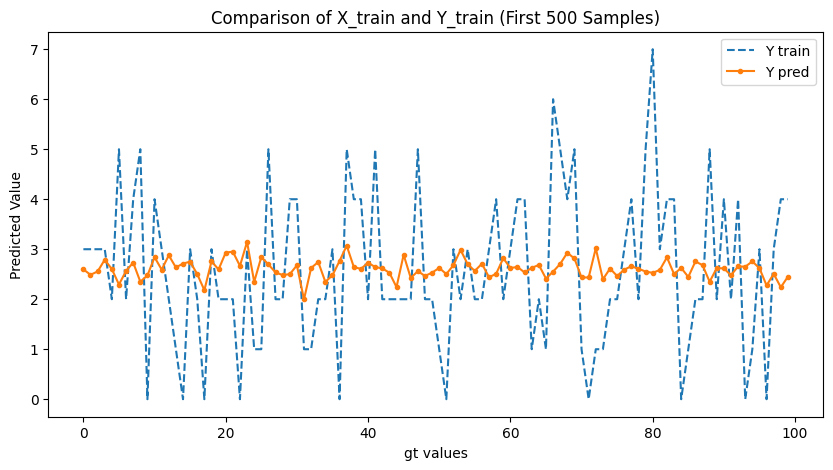

In [48]:
import matplotlib.pyplot as plt
Y_train_values = Y_train[:100]

Y_pred_values = Y_pred[:100]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(100), Y_train_values, label="Y train", linestyle="dashed")
plt.plot(range(100), Y_pred_values, label="Y pred", marker="o", markersize=3)

plt.xlabel("gt values")
plt.ylabel("Predicted Value")
plt.title("Comparison of Y_train and Y_pred")
plt.legend()
plt.show()